In [134]:
import pandas as pd
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
from datetime import timedelta
import datetime

# Please read, my idea was to classify the data into three cateogries: "UP", "DOWN", "NEUTRAL"
# UP - the price of the stock is up MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# DOWN - the price of the stock is down MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# NEUTRAL - the price of stock is did not rise or fall past the MINIMUM_GAIN threshhold
#
# EXAMPLE: LOOK_AHEAD_DAYS = 30, MINIMUM_GAIN = .05 (5%). If stock is up over 5% ore more after 30 days, 
# we mark it as 'UP'. If the stock is down 5% or more after 30 days, we mark it as 'DOWN'. If the stock
# is neither up nor down 5%, then we mark it as 'NEUTRAL'

# MINIMUM_GAIN = .05 #minimal gain to be considered up or down for classification, UNUSED NOW

LOOK_BACK_DAYS = 30 #number of days into the past we would like to take into account
LOOK_AHEAD_DAYS = 1 #number of days into the future we are trying to predict

class Utilities:

    @staticmethod
    def getData(ticker, start_date, end_date):
        try:
            stock_data = data.DataReader(ticker,
                                         'yahoo',
                                         start_date,
                                         end_date)
            return stock_data
        except RemoteDataError:
            print('No data found for {t}'.format(t=ticker))
#just get the btc price points from the past year
start_date = datetime.datetime.now() - timedelta(365)
end_date = datetime.datetime.now() - timedelta(1)
btc_df = Utilities.getData('BTC-USD', str(start_date.strftime('%Y-%m-%d')), str(end_date.strftime('%Y-%m-%d')))
btc_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-07,11979.419922,11556.167969,11954.040039,11966.407227,1.948159e+10,11966.407227
2019-08-08,11970.458008,11709.745117,11953.469727,11862.936523,1.833999e+10,11862.936523
2019-08-09,11915.655273,11323.898438,11861.556641,11354.024414,1.812536e+10,11354.024414
2019-08-10,11523.579102,11248.294922,11349.740234,11523.579102,1.577437e+10,11523.579102
2019-08-11,11528.189453,11320.951172,11528.189453,11382.616211,1.364720e+10,11382.616211
...,...,...,...,...,...,...
2020-08-01,12034.144531,11018.129883,11758.764648,11053.614258,2.741007e+10,11053.614258
2020-08-02,11453.079102,11012.415039,11043.768555,11246.348633,2.027171e+10,11246.348633
2020-08-04,11786.617188,11158.285156,11203.823242,11747.022461,2.441125e+10,11747.022461


In [135]:
def createLookBackCols():
    for i in range(LOOK_BACK_DAYS):
        num_rows= btc_df.shape[0]
        num_cols= btc_df.shape[1]
        btc_df.insert(loc = num_cols, column = 'High_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Low_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Open_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Volume_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Adj Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        
createLookBackCols() #create additional look back columns
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
    if (current_date - start_date).days >= LOOK_BACK_DAYS - 1:
        for i in range(LOOK_BACK_DAYS):
            index = i + 1
            look_back_date = current_date - timedelta(days=index)
            
            while True: #we need to keep subtracting days to the look_back_date because there is no index for that day
                if look_back_date in btc_df.index:
                    break
                look_back_date = look_back_date - timedelta(days=1)
            
            btc_df.at[pd.Timestamp(current_date), 'High_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'High']
            btc_df.at[pd.Timestamp(current_date), 'Low_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Low']
            btc_df.at[pd.Timestamp(current_date), 'Open_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Open']
            btc_df.at[pd.Timestamp(current_date), 'Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Close']
            btc_df.at[pd.Timestamp(current_date), 'Volume_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Volume']
            btc_df.at[pd.Timestamp(current_date), 'Adj Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Adj Close']

btc_df = btc_df[btc_df.High_Past_1 != 'N/A']
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,...,Close_Past_29,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-07,10595.637695,10409.090820,10518.114258,10441.276367,1.367057e+10,10441.276367,10517.3,1.53074e+10,10517.3,10353.9,...,11354,11861.6,11323.9,11915.7,11862.9,1.834e+10,11862.9,11953.5,11709.7,11970.5
2019-09-08,10450.311523,10144.929688,10443.228516,10334.974609,1.759594e+10,10334.974609,10441.3,1.36706e+10,10441.3,10518.1,...,11523.6,11349.7,11248.3,11523.6,11354,1.81254e+10,11354,11861.6,11323.9,11915.7
2019-09-09,10394.353516,10020.573242,10336.408203,10115.975586,1.490681e+10,10115.975586,10335,1.75959e+10,10335,10443.2,...,11382.6,11528.2,11321,11528.2,11523.6,1.57744e+10,11523.6,11349.7,11248.3,11523.6
2019-09-10,10215.948242,9980.776367,10123.035156,10178.372070,1.542806e+10,10178.372070,10116,1.49068e+10,10116,10336.4,...,10895.8,11385.1,10830.3,11420,11382.6,1.36472e+10,11382.6,11528.2,11321,11528.2
2019-09-11,10442.253906,10099.242188,10176.819336,10410.126953,1.532356e+10,10410.126953,10178.4,1.54281e+10,10178.4,10123,...,10051.7,10889.5,10028.1,10889.6,10895.8,1.66815e+10,10895.8,11385.1,10830.3,11420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,12034.144531,11018.129883,11758.764648,11053.614258,2.741007e+10,11053.614258,11759.6,2.60757e+10,11759.6,11322.6,...,9132.49,9084.23,9053.63,9183.3,9087.3,1.3079e+10,9087.3,9124.84,9058.79,9202.34
2020-08-02,11453.079102,11012.415039,11043.768555,11246.348633,2.027171e+10,11246.348633,11053.6,2.74101e+10,11053.6,11758.8,...,9073.94,9126.09,8977.02,9162.18,9132.49,1.22905e+10,9132.49,9084.23,9053.63,9183.3
2020-08-04,11786.617188,11158.285156,11203.823242,11747.022461,2.441125e+10,11747.022461,11246.3,2.02717e+10,11246.3,11043.8,...,9252.28,9349.16,9201.82,9360.62,9375.47,1.78893e+10,9375.47,9072.85,9058.66,9375.47


In [136]:
btc_df = btc_df.assign(MonthTrend=lambda x: "N/A") #introduce new column that will be the trend we are predicting
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

#Populate the classification column MonthTrend
for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
   
    if (end_date - current_date).days > LOOK_AHEAD_DAYS:
        look_ahead_date = current_date + timedelta(days=LOOK_AHEAD_DAYS)
        
        while True: #we need to keep adding days to the look_ahead_date because there is no index for that day
            if look_ahead_date in btc_df.index:
                break
            look_ahead_date = look_ahead_date + timedelta(days=1)
        
        #Here we check if the open price in the future is higher than today's open price.
        if btc_df.loc[pd.Timestamp(look_ahead_date)]['Open'] > btc_df.loc[index]['Open']:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'UP'
        else:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'DOWN'
            
#Now delete all columns that have a MonthTrend value of N/A
btc_df = btc_df[btc_df.MonthTrend != 'N/A']

#Data is now fully processed and ready to be trained on the machine learning model
#There are 3 values for MonthTrend: UP, DOWN
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,...,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-08,10450.311523,10144.929688,10443.228516,10334.974609,1.759594e+10,10334.974609,10441.3,1.36706e+10,10441.3,10518.1,...,11349.7,11248.3,11523.6,11354,1.81254e+10,11354,11861.6,11323.9,11915.7,DOWN
2019-09-09,10394.353516,10020.573242,10336.408203,10115.975586,1.490681e+10,10115.975586,10335,1.75959e+10,10335,10443.2,...,11528.2,11321,11528.2,11523.6,1.57744e+10,11523.6,11349.7,11248.3,11523.6,DOWN
2019-09-10,10215.948242,9980.776367,10123.035156,10178.372070,1.542806e+10,10178.372070,10116,1.49068e+10,10116,10336.4,...,11385.1,10830.3,11420,11382.6,1.36472e+10,11382.6,11528.2,11321,11528.2,DOWN
2019-09-11,10442.253906,10099.242188,10176.819336,10410.126953,1.532356e+10,10410.126953,10178.4,1.54281e+10,10178.4,10123,...,10889.5,10028.1,10889.6,10895.8,1.66815e+10,10895.8,11385.1,10830.3,11420,UP
2019-09-12,10441.489258,10226.596680,10415.362305,10360.546875,1.410986e+10,10360.546875,10410.1,1.53236e+10,10410.1,10176.8,...,10038.4,9675.32,10437.4,10051.7,1.99908e+10,10051.7,10889.5,10028.1,10889.6,UP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31,11794.775391,11239.682617,11322.570312,11759.592773,2.607567e+10,11759.592773,11323.5,2.31605e+10,11323.5,11110.2,...,9124.84,9058.79,9202.34,9123.41,1.63389e+10,9123.41,9231.14,9036.62,9274.96,UP
2020-08-01,12034.144531,11018.129883,11758.764648,11053.614258,2.741007e+10,11053.614258,11759.6,2.60757e+10,11759.6,11322.6,...,9084.23,9053.63,9183.3,9087.3,1.3079e+10,9087.3,9124.84,9058.79,9202.34,UP
2020-08-02,11453.079102,11012.415039,11043.768555,11246.348633,2.027171e+10,11246.348633,11053.6,2.74101e+10,11053.6,11758.8,...,9126.09,8977.02,9162.18,9132.49,1.22905e+10,9132.49,9084.23,9053.63,9183.3,DOWN


In [137]:
def generateFeatures(features):
    complete_features = []
    for feature in features:
        complete_features.append(feature)
        for i in range(LOOK_BACK_DAYS):
            complete_features.append(feature + "_Past_" + str(i + 1))
    return complete_features

features = generateFeatures(['Close','Open'])
features.append('MonthTrend')

# selecting the important feature open close
btc = btc_df[features]
btc.head(10)

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,...,Open_Past_22,Open_Past_23,Open_Past_24,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-08,10334.974609,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,...,10233,10358.7,10319.4,10038.4,10889.5,11385.1,11528.2,11349.7,11861.6,DOWN
2019-09-09,10115.975586,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,...,10350.3,10233,10358.7,10319.4,10038.4,10889.5,11385.1,11528.2,11349.7,DOWN
2019-09-10,10178.372070,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,...,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,11385.1,11528.2,DOWN
2019-09-11,10410.126953,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,...,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,11385.1,UP
2019-09-12,10360.546875,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,...,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,UP
2019-09-13,10358.048828,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,...,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,DOWN
2019-09-14,10347.712891,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,...,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,UP
2019-09-15,10276.793945,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,...,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,DOWN
2019-09-16,10241.272461,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,...,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,DOWN


In [138]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
Y = btc['MonthTrend']
X = btc.drop(['MonthTrend'], axis=1)
X = StandardScaler().fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=2)

In [139]:
# decision tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=45)
param_grid = {'splitter': ["best","random"],  
              'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
             'max_leaf_nodes':[10,50,None]}  
grid =  GridSearchCV(model_tree,param_grid,scoring="accuracy", cv=10, verbose=1,n_jobs=6)
grid.fit(X_train,Y_train)
print(grid.best_params_)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 2868 tasks      | elapsed:    1.0s


{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_samples_split': 2, 'splitter': 'best'}


[Parallel(n_jobs=6)]: Done 5760 out of 5760 | elapsed:    1.9s finished
C:\Users\Mao\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [140]:
# error rate
model_tree = OneVsRestClassifier(DecisionTreeClassifier(criterion='gini',min_samples_split=2,splitter="best",max_features="auto",
                                    max_leaf_nodes=10,max_depth=6))
model_tree.fit(X_train,Y_train)
tree_error_rate = 1 - model_tree.score(X_test,Y_test)
tree_error_rate

0.49

In [141]:
model_tree.score(X_train, Y_train)

0.6753246753246753

In [142]:
#confusion matrix and classification for testing
from sklearn.metrics import classification_report,multilabel_confusion_matrix,roc_curve, auc
import matplotlib.pylab as plt
prediction = model_tree.predict(X_test)
print(multilabel_confusion_matrix(Y_test, prediction))

[[[ 8 39]
  [10 43]]

 [[43 10]
  [39  8]]]


In [143]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

        DOWN       0.52      0.81      0.64        53
          UP       0.44      0.17      0.25        47

    accuracy                           0.51       100
   macro avg       0.48      0.49      0.44       100
weighted avg       0.49      0.51      0.45       100



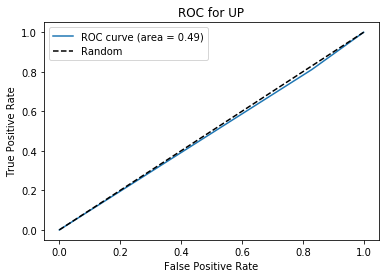

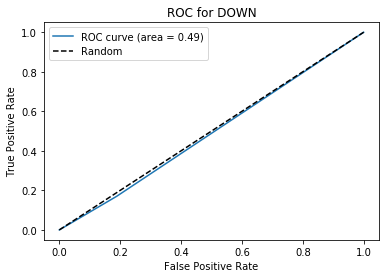

In [144]:
 # Plot the ROC curve

def plot_roc(Y_test,Y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes= 2
    Y_test_dummies = pd.get_dummies(Y_test, drop_first=False).values
    Y_pred_dummies = pd.get_dummies(Y_pred,drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_dummies[:, i],Y_pred_dummies[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    title = ["ROC for UP", "ROC for DOWN"]
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--', label="Random")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title[i])
        plt.legend(loc="best")
        plt.show()
plot_roc(Y_test,prediction)

In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
model_random = RandomForestClassifier(random_state=42)
param_grid = {
             'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
              'min_samples_leaf':[1,2,4,6],
             'max_leaf_nodes':[10,50,None]}  
random_grid =  GridSearchCV(model_random,param_grid,scoring="accuracy", cv=10, verbose=1,n_jobs=6)
random_grid.fit(X_train,Y_train)
print(random_grid.best_params_)

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 632 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done 5732 tasks      | elapsed:   10.4s


In [ ]:
model_random_tree = OneVsRestClassifier(RandomForestClassifier(criterion= 'gini',min_samples_split=2,max_features="auto",
                                    max_leaf_nodes=10,max_depth=6,min_samples_leaf=6))
model_random_tree.fit(X_train,Y_train)
tree_error_rate = 1 - model_random_tree.score(X_test,Y_test)
tree_error_rate

In [ ]:
model_random_tree.score(X_train, Y_train)

In [ ]:
new_prediction = model_random_tree.predict(X_test)
print(multilabel_confusion_matrix(Y_test, new_prediction))

In [ ]:
print(classification_report(Y_test, new_prediction))

In [ ]:
plot_roc(Y_test,new_prediction)